In [1]:
# install libraries for Google Colab
!pip install --upgrade tables
!pip install eli5
!pip install scikit-plot
!pip install xgboost
!pip install hyperopt

     |████████████████████████████████| 4.3MB 7.2MB/s 
  Found existing installation: tables 3.4.4
    Uninstalling tables-3.4.4:
      Successfully uninstalled tables-3.4.4
     |████████████████████████████████| 112kB 8.9MB/s 


In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
# import libraries

import pandas as pd
import numpy as np
import joblib

from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit, train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler

# import models
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter Optimization
from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample


import eli5
from eli5.sklearn import PermutationImportance
from eli5.permutation_importance import get_score_importances

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
base_color = sns.color_palette()[0]
import scikitplot as skplt

import warnings
warnings.filterwarnings('ignore')

#show all columns and rows
pd.options.display.max_rows = None
pd.options.display.max_columns = None


random_state=2020

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pand

## Load the data

In [2]:
cd '/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution'

/content/drive/My Drive/Colab Notebooks/DataWorkshop_Competition_Warsaw_Air_Pollution


In [3]:
# load the wrangled and transformed data 
df = pd.read_hdf('data/warsaw_air_pollution_2015-2019_feature_eng.h5', key='df')

In [4]:
df.head()

,datetime,apparentTemperature,cloudCover,dewPoint,humidity,icon,precipIntensity,precipProbability,pressure,summary,temperature,uvIndex,visibility,windBearing,windSpeed,PM25_nie,PM25_wok,hour,day,dayofyear,weekday,month,year,IsWeekend,PM25_nie_mean,PM25_wok_mean,humidity_log,windSpeed_log,PM25_nie_log,PM25_wok_log,apparentTemperature_lag1h,cloudCover_lag1h,dewPoint_lag1h,humidity_lag1h,humidity_log_lag1h,precipIntensity_lag1h,precipProbability_lag1h,pressure_lag1h,temperature_lag1h,uvIndex_lag1h,visibility_lag1h,windBearing_lag1h,windSpeed_lag1h,windSpeed_log_lag1h,apparentTemperature_lag24h,cloudCover_lag24h,dewPoint_lag24h,humidity_lag24h,humidity_log_lag24h,precipIntensity_lag24h,precipProbability_lag24h,pressure_lag24h,temperature_lag24h,uvIndex_lag24h,visibility_lag24h,windBearing_lag24h,windSpeed_lag24h,windSpeed_log_lag24h,apparentTemperature_rolling12h,cloudCover_rolling12h,dewPoint_rolling12h,humidity_rolling12h,humidity_log_rolling12h,precipIntensity_rolling12h,precipProbability_rolling12h,pressure_rolling12h,temperature_rolling12h,uvIndex_rolling12h,visibility_rolling12h,windBearing_rolling12h,windSpeed_rolling12h,windSpeed_log_rolling12h,apparentTemperature_rolling24h,cloudCover_rolling24h,dewPoint_rolling24h,humidity_rolling24h,humidity_log_rolling24h,precipIntensity_rolling24h,precipProbability_rolling24h,pressure_rolling24h,temperature_rolling24h,uvIndex_rolling24h,visibility_rolling24h,windBearing_rolling24h,windSpeed_rolling24h,windSpeed_log_rolling24h,apparentTemperature_rolling72h,cloudCover_rolling72h,dewPoint_rolling72h,humidity_rolling72h,humidity_log_rolling72h,precipIntensity_rolling72h,precipProbability_rolling72h,pressure_rolling72h,temperature_rolling72h,uvIndex_rolling72h,visibility_rolling72h,windBearing_rolling72h,windSpeed_rolling72h,windSpeed_log_rolling72h,apparentTemperature_rolling168h,cloudCover_rolling168h,dewPoint_rolling168h,humidity_rolling168h,humidity_log_rolling168h,precipIntensity_rolling168h,precipProbability_rolling168h,pressure_rolling168h,temperature_rolling168h,uvIndex_rolling168h,visibility_rolling168h,windBearing_rolling168h,windSpeed_rolling168h,windSpeed_log_rolling168h,mean_apparentTemperature_per_day,mean_cloudCover_per_day,mean_dewPoint_per_day,mean_humidity_per_day,mean_humidity_log_per_day,mean_precipIntensity_per_day,mean_precipProbability_per_day,mean_pressure_per_day,mean_temperature_per_day,mean_uvIndex_per_day,mean_visibility_per_day,mean_windBearing_per_day,mean_windSpeed_per_day,mean_windSpeed_log_per_day,mean_PM25_nie_per_day,mean_PM25_wok_per_day,mean_PM25_nie_log_per_day,mean_PM25_wok_log_per_day,median_apparentTemperature_per_day,median_cloudCover_per_day,median_dewPoint_per_day,median_humidity_per_day,median_humidity_log_per_day,median_precipIntensity_per_day,median_precipProbability_per_day,median_pressure_per_day,median_temperature_per_day,median_uvIndex_per_day,median_visibility_per_day,median_windBearing_per_day,median_windSpeed_per_day,median_windSpeed_log_per_day,median_PM25_nie_per_day,median_PM25_wok_per_day,median_PM25_nie_log_per_day,median_PM25_wok_log_per_day,mean_apparentTemperature_per_month,mean_cloudCover_per_month,mean_dewPoint_per_month,mean_humidity_per_month,mean_humidity_log_per_month,mean_precipIntensity_per_month,mean_precipProbability_per_month,mean_pressure_per_month,mean_temperature_per_month,mean_uvIndex_per_month,mean_visibility_per_month,mean_windBearing_per_month,mean_windSpeed_per_month,mean_windSpeed_log_per_month,mean_PM25_nie_per_month,mean_PM25_wok_per_month,mean_PM25_nie_log_per_month,mean_PM25_wok_log_per_month,median_apparentTemperature_per_month,median_cloudCover_per_month,median_dewPoint_per_month,median_humidity_per_month,median_humidity_log_per_month,median_precipIntensity_per_month,median_precipProbability_per_month,median_pressure_per_month,median_temperature_per_month,median_uvIndex_per_month,median_visibility_per_month,median_windBearing_per_month,median_windSpeed_per_month,median_windSpeed_log_per_month,median_PM

#### Split the data for train and test

In [5]:
# split the df for train and test, leave last 6 month for the test
train_mask = df['datetime'] < '2019-07-01'
test_mask = df['datetime'] >= '2019-07-01'

df_train = df.loc[train_mask]
df_test = df.loc[test_mask]

In [6]:
# check if the train dataset is correctly split
df_train.datetime.min(), df_train.datetime.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2019-06-30 23:00:00'))

In [7]:
# check if the test dataset is correctly split
df_test.datetime.min(), df_test.datetime.max()

(Timestamp('2019-07-01 00:00:00'), Timestamp('2019-12-31 23:00:00'))

## Create functions for quick iterations and scoring

In [8]:
# function to run different models
def run_model(model, X, y, cross_val):
    model_name = type(model).__name__

    rmse = np.sqrt(-cross_val_score(model, X, y, cv=cross_val, scoring='neg_mean_squared_error'))
    r2 = cross_val_score(model, X, y, cv=cross_val, scoring='r2')
    print("{} RMSE: {:.4f}, r2: {:.1f}%".format(model_name, np.mean(rmse), 100*np.mean(r2)))

In [9]:
# function to plot a learning curve for different models and scoring
def plot_lear_curve(model, X, y, cross_val, scoring, ax):

  model_name = type(model).__name__
  skplt.estimators.plot_learning_curve(model, X, y, cv=cross_val, scoring=scoring,
                                       title=f'{model_name} Learning Curve', ax=ax);

In [10]:
# function to plot a feature importances for different models and scoring
def plot_feature_importances(model, feat_list, ax):

  model_name = type(model).__name__
  skplt.estimators.plot_feature_importances(model, feature_names=df_train[feat_list].columns,
                                            title=f'{model_name} feature importances', ax=ax)
  plt.xticks(rotation=90)

##Define cross-validation and initiate simple models for benchmarking purpose

In [11]:
# define Cross Validation
tcsv = TimeSeriesSplit(n_splits=5)
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

# define simple models for fast testing
Dummy_model = DummyRegressor(strategy="mean")
DT_model = DecisionTreeRegressor(max_depth=3, random_state=random_state)
RF_model = RandomForestRegressor(max_depth=3, random_state=random_state)
XGB_model = xgb.XGBRegressor(max_depth=3, objective='reg:squarederror', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(max_depth=3, objective='regression', random_state=random_state)

# add all models to a list
models = [Dummy_model, DT_model, RF_model, XGB_model, LGBM_model]

###Run and evaluate models on original darksky.net features

In [12]:
# select original features from darksky.net
orig_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity',
              'precipProbability', 'pressure', 'temperature', 'uvIndex',
              'visibility', 'windBearing', 'windSpeed', 'icon_num']

In [13]:
# define X_train, y_train for original features
X_train = df_train[orig_feats].values
y_train = df_train['PM25_nie_log'].values

# define X_test, y_test for original features
X_test = df_test[orig_feats].values
y_test = df_test['PM25_nie_log'].values

In [14]:
# evaluate models on time series split
for model in models:
    run_model(model, X_train, y_train, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.4983, r2: 23.5%
RandomForestRegressor RMSE: 0.4819, r2: 28.6%
XGBRegressor RMSE: 0.4579, r2: 31.4%
LGBMRegressor RMSE: 0.4612, r2: 29.9%


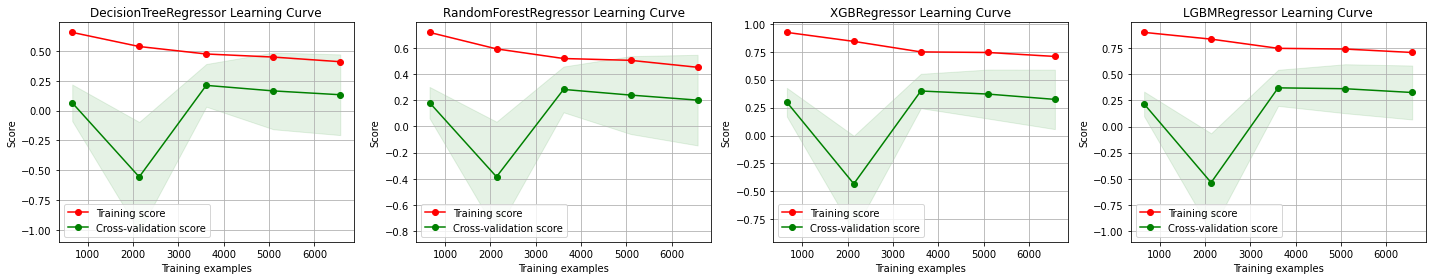

In [15]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_lear_curve(model, X_train, y_train, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [16]:
# evaluate models on KFold
for model in models:
    run_model(model, X_train, y_train, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4769, r2: 39.0%
RandomForestRegressor RMSE: 0.4716, r2: 40.3%
XGBRegressor RMSE: 0.3975, r2: 57.6%
LGBMRegressor RMSE: 0.3972, r2: 57.7%


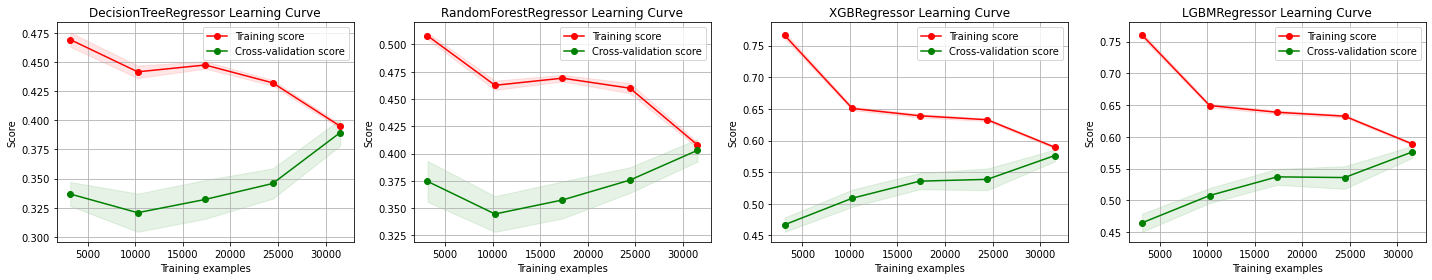

In [17]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Fit models and check feature importances

In [18]:
# fit models
Dummy_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

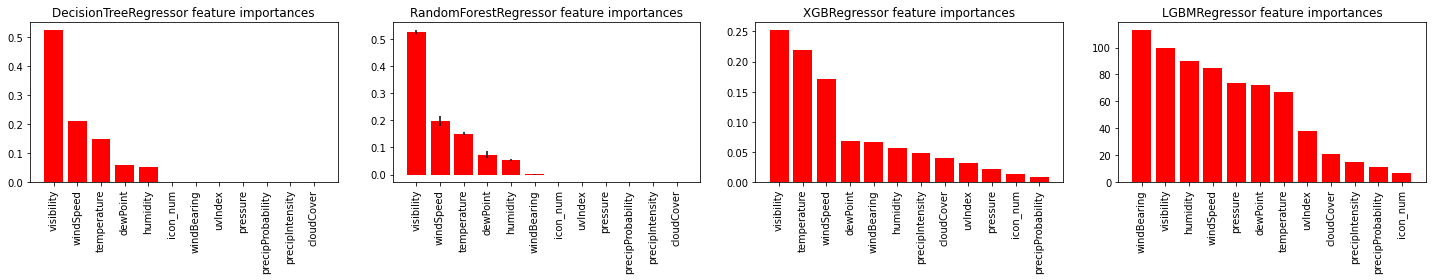

In [19]:
# check feature importances for models ran on KFold
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_feature_importances(model, orig_feats, ax=ax)
fig.tight_layout()
plt.show()

###Predict on test data

In [20]:
# predict on all feats 
y_test_Dummy_orig = Dummy_model.predict(X_test)
y_test_DT_orig = DT_model.predict(X_test)
y_test_RF_orig = RF_model.predict(X_test)
y_test_XGB_orig = XGB_model.predict(X_test)
y_test_LGBM_orig = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_dummy_orig'] = np.expm1(y_test_Dummy_orig)
df_test['PM25_nie_pred_DT_orig'] = np.expm1(y_test_DT_orig)
df_test['PM25_nie_pred_RF_orig'] = np.expm1(y_test_RF_orig)
df_test['PM25_nie_pred_XGB_orig'] = np.expm1(y_test_XGB_orig)
df_test['PM25_nie_pred_LGBM_orig'] = np.expm1(y_test_LGBM_orig)

In [21]:
# check RMSE for test data on all feats
dummy_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_orig']))
dt_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_orig']))
rf_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_orig']))
xgb_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_orig']))
lgbm_rmse_orig = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_orig']))

# check r2 for test data on all feats
dummy_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_orig'])
dt_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_orig'])
rf_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_orig'])
xgb_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_orig'])
lgbm_r2_orig = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_orig'])

In [22]:
print("-----RMSE and r2 results on the test data using original features-----")
print("Dummy Regressor: RMSE: {:.4f}, r2: {:.1f}%".format(dummy_rmse_orig, 100*np.mean(dummy_r2_orig)))
print("Decision Tree: RMSE: {:.4f}, r2: {:.1f}%".format(dt_rmse_orig, 100*np.mean(dt_r2_orig)))
print("Random Forest: RMSE: {:.4f}, r2: {:.1f}%".format(rf_rmse_orig, 100*np.mean(rf_r2_orig)))
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_orig, 100*np.mean(xgb_r2_orig)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_orig, 100*np.mean(lgbm_r2_orig)))

-----RMSE and r2 results on the test data using original features-----
Dummy Regressor: RMSE: 10.5207, r2: -1.1%
Decision Tree: RMSE: 10.3966, r2: 1.3%
Random Forest: RMSE: 10.3374, r2: 2.4%
XGBoost: RMSE: 8.4701, r2: 34.5%
LightGBM: RMSE: 8.5642, r2: 33.0%


###Run and evaluate models on original and time based features

In [23]:
# extend original features with new time based ones
time_feats = ['cloudCover', 'dewPoint', 'humidity', 'precipIntensity', 'precipProbability',
              'pressure', 'temperature', 'uvIndex', 'visibility', 'windBearing', 'windSpeed',
              'icon_num', 'Autumn', 'Spring', 'Summer', 'Winter',
              'year', 'month', 'day', 'dayofyear', 'hour', 'weekday', 'IsWeekend']

# define X_train
X_train = df_train[time_feats].values
X_test = df_test[time_feats].values

In [24]:
# evaluate models on time series split
for model in models:
    run_model(model, X_train, y_train, tcsv)

DummyRegressor RMSE: 0.6046, r2: -8.8%
DecisionTreeRegressor RMSE: 0.5104, r2: 19.3%
RandomForestRegressor RMSE: 0.4925, r2: 25.1%
XGBRegressor RMSE: 0.3997, r2: 50.7%
LGBMRegressor RMSE: 0.3983, r2: 50.9%


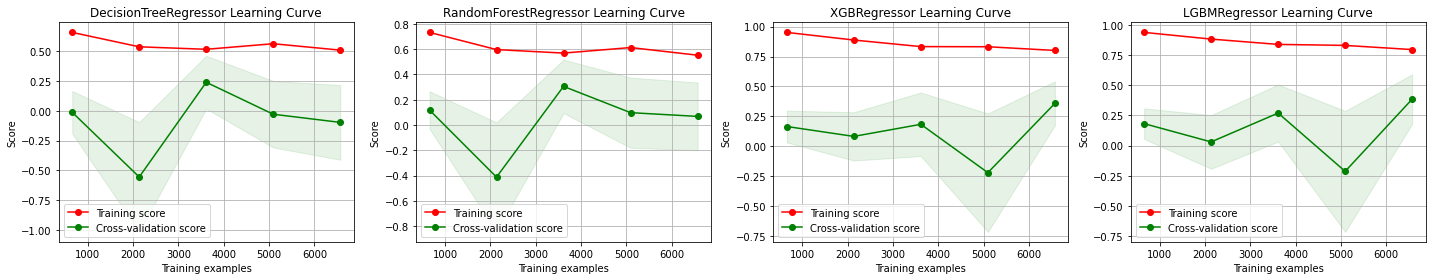

In [25]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_lear_curve(model, X_train, y_train, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [26]:
# evaluate models on KFold
for model in models:
    run_model(model, X_train, y_train, kf)

DummyRegressor RMSE: 0.6104, r2: -0.0%
DecisionTreeRegressor RMSE: 0.4706, r2: 40.5%
RandomForestRegressor RMSE: 0.4644, r2: 42.1%
XGBRegressor RMSE: 0.3504, r2: 67.0%
LGBMRegressor RMSE: 0.3499, r2: 67.1%


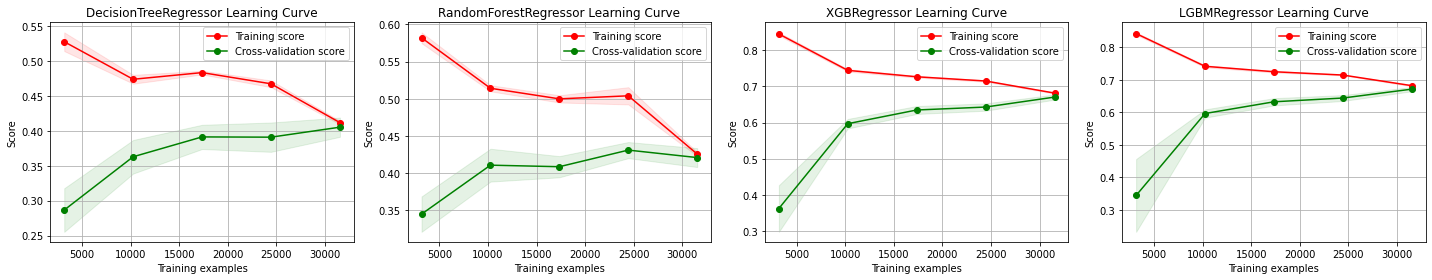

In [27]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Fit models and check feature importances

In [28]:
# fit models
Dummy_model.fit(X_train, y_train)
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

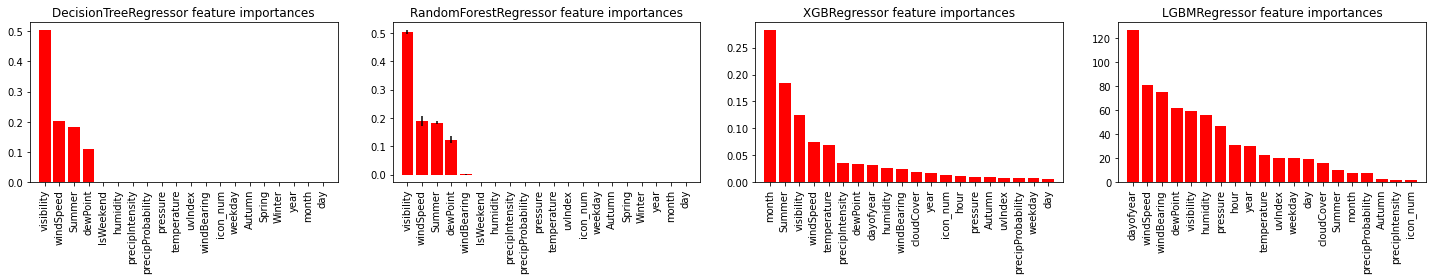

In [29]:
# check feature importances for models ran on KFold
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_feature_importances(model, time_feats, ax=ax)
fig.tight_layout()
plt.show()

###Predict on test data

In [30]:
# predict on all feats 
y_test_Dummy_time = Dummy_model.predict(X_test)
y_test_DT_time = DT_model.predict(X_test)
y_test_RF_time = RF_model.predict(X_test)
y_test_XGB_time = XGB_model.predict(X_test)
y_test_LGBM_time = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_dummy_time'] = np.expm1(y_test_Dummy_time)
df_test['PM25_nie_pred_DT_time'] = np.expm1(y_test_DT_time)
df_test['PM25_nie_pred_RF_time'] = np.expm1(y_test_RF_time)
df_test['PM25_nie_pred_XGB_time'] = np.expm1(y_test_XGB_time)
df_test['PM25_nie_pred_LGBM_time'] = np.expm1(y_test_LGBM_time)

In [31]:
# check RMSE for test data on all feats
dummy_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_time']))
dt_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_time']))
rf_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_time']))
xgb_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_time']))
lgbm_rmse_time = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_time']))

# check r2 for test data on all feats
dummy_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_dummy_time'])
dt_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_time'])
rf_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_time'])
xgb_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_time'])
lgbm_r2_time = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_time'])

In [32]:
print("-----RMSE and r2 results on the test data using original and time-based features-----")
print("Dummy Regressor: RMSE: {:.4f}, r2: {:.1f}%".format(dummy_rmse_time, 100*np.mean(dummy_r2_time)))
print("Decision Tree: RMSE: {:.4f}, r2: {:.1f}%".format(dt_rmse_time, 100*np.mean(dt_r2_time)))
print("Random Forest: RMSE: {:.4f}, r2: {:.1f}%".format(rf_rmse_time, 100*np.mean(rf_r2_time)))
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_time, 100*np.mean(xgb_r2_time)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_time, 100*np.mean(lgbm_r2_time)))

-----RMSE and r2 results on the test data using original and time-based features-----
Dummy Regressor: RMSE: 10.5207, r2: -1.1%
Decision Tree: RMSE: 10.0089, r2: 8.5%
Random Forest: RMSE: 9.9534, r2: 9.5%
XGBoost: RMSE: 7.3032, r2: 51.3%
LightGBM: RMSE: 7.2515, r2: 52.0%


###Run and evaluate models on all features except blacklisted

In [33]:
# function to get all numerical features, except the one related to PM2.5 and Wokalna Street measures
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = [
                  # Niepodleglosci
                  'PM25_nie', 'PM25_nie_log', 'PM25_nie_mean', 'mean_PM25_nie_per_day',
                  'mean_PM25_nie_log_per_day', 'median_PM25_nie_per_day', 'median_PM25_nie_log_per_day',
                  'mean_PM25_nie_per_month', 'mean_PM25_nie_log_per_month', 'median_PM25_nie_per_month',
                  'median_PM25_nie_log_per_month',
                  # Wokalna
                  'PM25_wok', 'PM25_wok_log', 'PM25_wok_mean', 'mean_PM25_wok_per_day', 
                  'mean_PM25_wok_log_per_day', 'median_PM25_wok_per_day', 'median_PM25_wok_log_per_day',
                  'mean_PM25_wok_per_month', 'mean_PM25_wok_log_per_month', 'median_PM25_wok_per_month',
                  'median_PM25_wok_log_per_month',
                  # features increasing RMSE and decreasing r2 results
                  'temperature_12-24h_ma_diff', 'apparentTemperature_12-24h_ma_diff', 'dewPoint_12-24h_ma_diff',
                  'humidity_12-24h_ma_diff', 'windSpeed_12-24h_ma_diff', 'windBearing_12-24h_ma_diff',
                  'isHumidWorkingDay', 'isColdWorkingDay', 'isWindlessWorkingDay', 'isWindlessColdHumidWorkingDay',
                  'NonWorkingHoursInWeek', 'NonWorkingHumidHoursInWeek', 'NonWorkingColdHoursInWeek',	
                  'NonWorkingWindlessHoursInWeek', 'NonWorkingWindlessColdHumidHoursInWeek'
                  ]
                  
    return [x for x in feats if x not in black_list]

In [34]:
#get feats
feats = get_feats(df_train)

# define X_train
X_train = df_train[feats].values
X_test = df_test[feats].values

In [35]:
# evaluate models on time series split
for model in models[1:]:
    run_model(model, X_train, y_train, tcsv)

DecisionTreeRegressor RMSE: 0.5067, r2: 20.0%
RandomForestRegressor RMSE: 0.4669, r2: 32.3%
XGBRegressor RMSE: 0.3640, r2: 58.7%
LGBMRegressor RMSE: 0.3656, r2: 58.4%


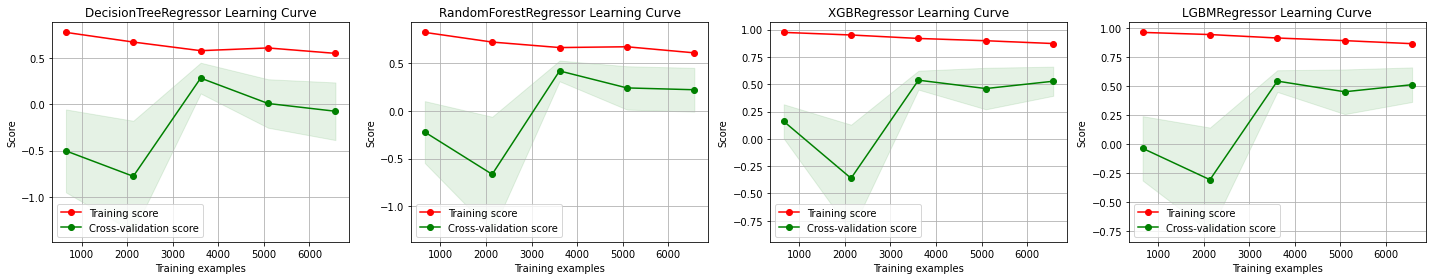

In [36]:
# check r2 learning curve for models ran on time series split
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_lear_curve(model, X_train, y_train, tcsv, 'r2', ax=ax)
fig.tight_layout()
plt.show()

In [37]:
# evaluate models on KFold
for model in models[1:]:
    run_model(model, X_train, y_train, kf)

DecisionTreeRegressor RMSE: 0.4373, r2: 48.7%
RandomForestRegressor RMSE: 0.4264, r2: 51.2%
XGBRegressor RMSE: 0.3012, r2: 75.6%
LGBMRegressor RMSE: 0.3013, r2: 75.6%


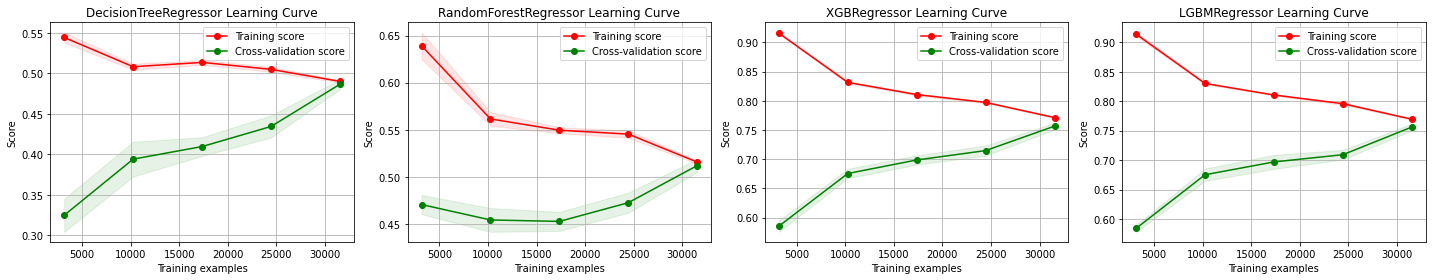

In [38]:
# check r2 learning curve for models ran on KFold
fig=plt.figure(figsize=(20,4))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Fit models and check feature importances

In [39]:
# fit models
DT_model.fit(X_train, y_train)
RF_model.fit(X_train, y_train)
XGB_model.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=3,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

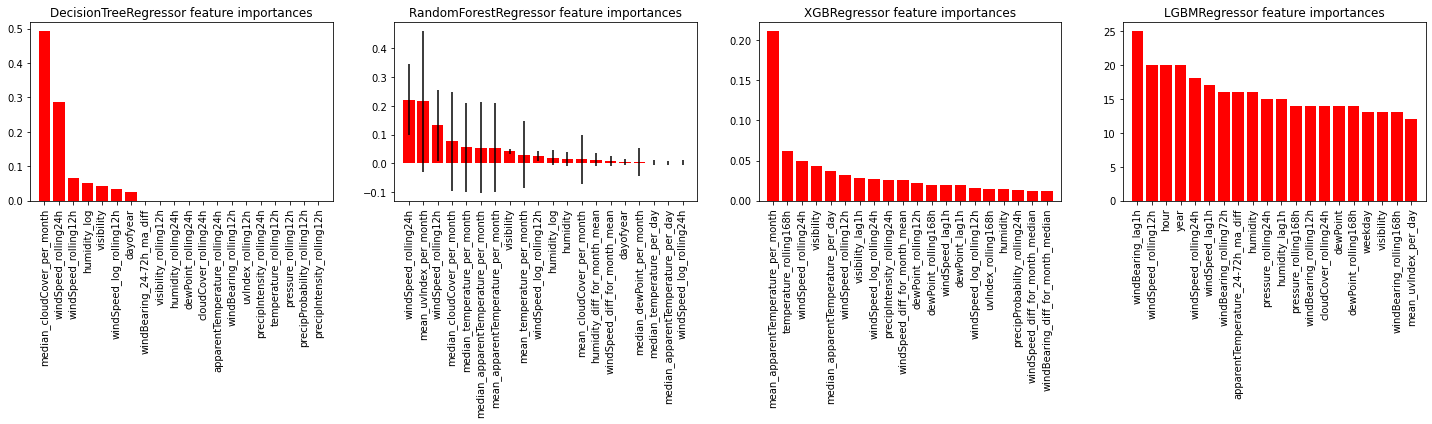

In [40]:
# check feature importances for models ran on KFold
fig=plt.figure(figsize=(20,6))
for i, model in enumerate(models[1:]):
    ax=fig.add_subplot(1,4,i+1)
    plot_feature_importances(model, feats, ax=ax)
fig.tight_layout()
plt.show()

###Predict on test data

In [41]:
# predict on all feats
y_test_DT_all = DT_model.predict(X_test)
y_test_RF_all = RF_model.predict(X_test)
y_test_XGB_all = XGB_model.predict(X_test)
y_test_LGBM_all = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_DT_all'] = np.expm1(y_test_DT_all)
df_test['PM25_nie_pred_RF_all'] = np.expm1(y_test_RF_all)
df_test['PM25_nie_pred_XGB_all'] = np.expm1(y_test_XGB_all)
df_test['PM25_nie_pred_LGBM_all'] = np.expm1(y_test_LGBM_all)

In [42]:
# check RMSE for test data on all feats
dt_rmse_all = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_all']))
rf_rmse_all = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_all']))
xgb_rmse_all = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_all']))
lgbm_rmse_all = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_all']))

# check r2 for test data on all feats
dt_r2_all = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_DT_all'])
rf_r2_all = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_RF_all'])
xgb_r2_all = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_XGB_all'])
lgbm_r2_all = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_LGBM_all'])

In [43]:
print("-----RMSE and r2 results on the test data using all features-----")
print("Decision Tree: RMSE: {:.4f}, r2: {:.1f}%".format(dt_rmse_all, 100*np.mean(dt_r2_all)))
print("Random Forest: RMSE: {:.4f}, r2: {:.1f}%".format(rf_rmse_all, 100*np.mean(rf_r2_all)))
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_all, 100*np.mean(xgb_r2_all)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_all, 100*np.mean(lgbm_r2_all)))

-----RMSE and r2 results on the test data using all features-----
Decision Tree: RMSE: 8.4815, r2: 34.3%
Random Forest: RMSE: 8.3186, r2: 36.8%
XGBoost: RMSE: 6.8606, r2: 57.0%
LightGBM: RMSE: 6.6977, r2: 59.0%


##Parameters tuning with HyperOpt on all features except blacklisted

###Define XGBoost and Light GBM HyperOpt functions

In [44]:
# define hyperopt function for XGBoost
def run_xgb_hyperopt(X, y, tree_method, grow_policy, cv, max_evals, random_state):

    def objective(space):
        XGB_model = xgb.XGBRegressor(
            max_depth = int(space['max_depth']),
            n_estimators = int(space['n_estimators']),
            min_child_weight = space['min_child_weight'],
            subsample = space['subsample'],
            learning_rate = space['learning_rate'],
            gamma = space['gamma'],
            colsample_bytree = space['colsample_bytree'],
            objective='reg:squarederror',
            tree_method=tree_method,
            grow_policy=grow_policy,
            random_state=random_state)
        
        for train_idx, test_idx in cv.split(X):

            eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
            XGB_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
            y_pred = XGB_model.predict(X[test_idx])

            rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
            r2 = r2_score(y[test_idx], y_pred)
            
            print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
            return{'loss': rmse, 'status': STATUS_OK }
        
        
    space ={
            'max_depth': hp.choice('max_depth', np.arange(2, 4, 1, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
            'subsample': hp.uniform('subsample', 0.7, 1),
            'n_estimators' : hp.choice('n_estimators', np.arange(20, 150, 2, dtype=int)),
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
            'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
        }

    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=max_evals,
                trials=trials)
    hyperparams = space_eval(space, best)

    print("The best params: ", hyperparams)
    return hyperparams

In [45]:
# define hyperopt function for Light GBM
def run_lgbm_hyperopt(X, y, cv, max_evals, random_state):

    def objective(space):
        LGBM_model = lgb.LGBMRegressor(
            max_depth = int(space['max_depth']),
            n_estimators = int(space['n_estimators']),
            num_leaves = int(space['num_leaves']),
            min_child_weight = space['min_child_weight'],
            subsample = space['subsample'],
            learning_rate = space['learning_rate'],
            gamma = space['gamma'],
            colsample_bytree = space['colsample_bytree'],
            objective='regression',
            random_state=random_state)
        
        for train_idx, test_idx in cv.split(X):

            eval_set = [(X[train_idx], y[train_idx]), (X[test_idx], y[test_idx])]
            LGBM_model.fit(X[train_idx], y[train_idx], eval_set=eval_set, eval_metric = 'rmse', early_stopping_rounds=10, verbose=False)
            y_pred = LGBM_model.predict(X[test_idx])

            rmse = np.sqrt(mean_squared_error(y[test_idx], y_pred))
            r2 = r2_score(y[test_idx], y_pred)
            
            print("RMSE: {:.4f}, r2: {:.1f}%".format(rmse, 100*r2))
            return{'loss': rmse, 'status': STATUS_OK }
        
        
    space ={
            'max_depth': hp.choice('max_depth', np.arange(2, 4, 1, dtype=int)),
            'n_estimators' : hp.choice('n_estimators', np.arange(20, 200, 2, dtype=int)),
            'num_leaves' : hp.choice('num_leaves', np.arange(2, 30, 1, dtype=int)),
            'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
            'subsample': hp.uniform('subsample', 0.7, 1),
            'learning_rate' : hp.quniform('learning_rate', 0.025, 0.5, 0.025),
            'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
            'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05)
            }

    trials = Trials()
    best = fmin(fn=objective,
                space=space,
                algo=partial(tpe.suggest, n_startup_jobs=1),
                max_evals=max_evals,
                trials=trials)
    hyperparams = space_eval(space, best)

    print("The best params: ", hyperparams)
    return hyperparams

###Run and fit models

In [46]:
# run hyeropt for XGB model with grow_policy='depthwise'
best_XGB_depth = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='depthwise', cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.2625, r2: 81.6%
RMSE: 0.2903, r2: 77.5%
RMSE: 0.2892, r2: 77.7%
RMSE: 0.2799, r2: 79.1%
RMSE: 0.4023, r2: 56.8%
RMSE: 0.2749, r2: 79.8%
RMSE: 0.4149, r2: 54.1%
RMSE: 0.2949, r2: 76.8%
RMSE: 0.2953, r2: 76.7%
RMSE: 0.3182, r2: 73.0%
100%|██████████| 10/10 [01:28<00:00,  8.81s/it, best loss: 0.2624761609820748]
The best params:  {'colsample_bytree': 0.7000000000000001, 'gamma': 0.6000000000000001, 'learning_rate': 0.2, 'max_depth': 3, 'min_child_weight': 8.0, 'n_estimators': 138, 'subsample': 0.8848029896002215}


In [47]:
# run hyeropt for XGB model with grow_policy='lossguide'
best_XGB_leaf = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='lossguide', cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.2721, r2: 80.2%
RMSE: 0.2768, r2: 79.6%
RMSE: 0.2803, r2: 79.0%
RMSE: 0.4449, r2: 47.2%
RMSE: 0.2558, r2: 82.5%
RMSE: 0.2561, r2: 82.5%
RMSE: 0.3332, r2: 70.4%
RMSE: 0.9477, r2: -139.7%
RMSE: 0.2895, r2: 77.6%
RMSE: 0.2635, r2: 81.5%
100%|██████████| 10/10 [01:27<00:00,  8.79s/it, best loss: 0.25579275130470813]
The best params:  {'colsample_bytree': 0.75, 'gamma': 0.75, 'learning_rate': 0.4, 'max_depth': 3, 'min_child_weight': 3.0, 'n_estimators': 102, 'subsample': 0.865383165152124}


In [48]:
# run hyeropt for Light GBM model
best_LGBM = run_lgbm_hyperopt(X_train, y_train, cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.2343, r2: 85.3%
RMSE: 0.2448, r2: 84.0%
RMSE: 0.3112, r2: 74.2%
RMSE: 0.2339, r2: 85.4%
RMSE: 0.3179, r2: 73.0%
RMSE: 0.3020, r2: 75.7%
RMSE: 0.2971, r2: 76.4%
RMSE: 0.2852, r2: 78.3%
RMSE: 0.2655, r2: 81.2%
RMSE: 0.3437, r2: 68.5%
100%|██████████| 10/10 [00:38<00:00,  3.83s/it, best loss: 0.233910237418922]
The best params:  {'colsample_bytree': 1.0, 'gamma': 0.8500000000000001, 'learning_rate': 0.47500000000000003, 'max_depth': 3, 'min_child_weight': 1.0, 'n_estimators': 164, 'num_leaves': 26, 'subsample': 0.9861373205566042}


In [49]:
# initiate models with best params
XGB_model_depth = xgb.XGBRegressor(**best_XGB_depth, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_model_leaf = xgb.XGBRegressor(**best_XGB_leaf, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
LGBM_model = lgb.LGBMRegressor(**best_LGBM, objective='regression', random_state=random_state)

###Evaluate models

In [50]:
# evaluate models on KFold
models = [XGB_model_depth, XGB_model_leaf, LGBM_model]

for model in models:
    run_model(model, X_train, y_train, kf)

XGBRegressor RMSE: 0.2666, r2: 80.9%
XGBRegressor RMSE: 0.2603, r2: 81.8%
LGBMRegressor RMSE: 0.2373, r2: 84.9%


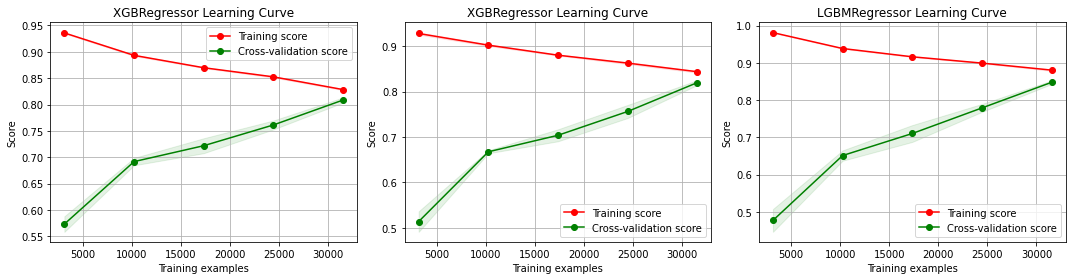

In [51]:
fig=plt.figure(figsize=(15,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

###Fit models and check feature importances

In [52]:
# fit models
XGB_model_depth.fit(X_train, y_train)
XGB_model_leaf.fit(X_train, y_train)
LGBM_model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              gamma=0.8500000000000001, importance_type='split',
              learning_rate=0.47500000000000003, max_depth=3,
              min_child_samples=20, min_child_weight=1.0, min_split_gain=0.0,
              n_estimators=164, n_jobs=-1, num_leaves=26,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.9861373205566042,
              subsample_for_bin=200000, subsample_freq=0)

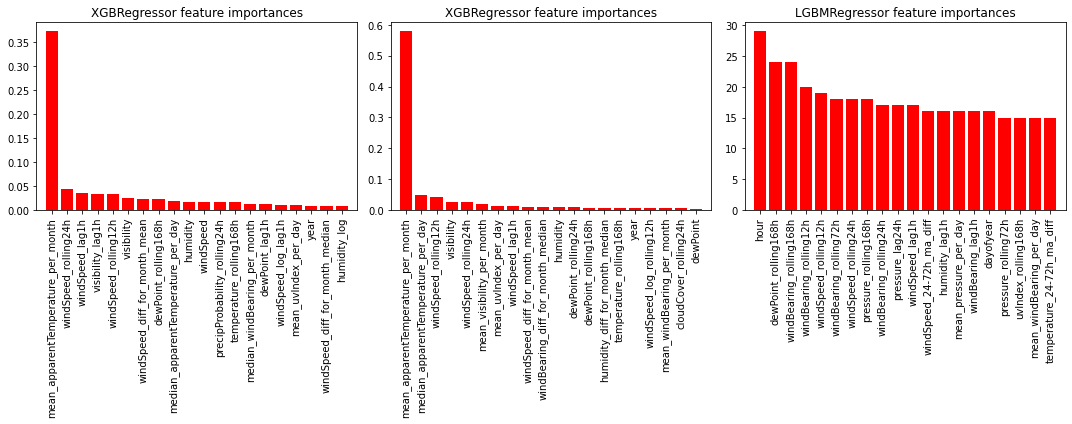

In [53]:
# check feature importances for models ran on KFold
fig=plt.figure(figsize=(15,6))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_feature_importances(model, feats, ax=ax)
fig.tight_layout()
plt.show()

In [54]:
# check perutation importance with eli5 for XGB model with grow_policy='depthwise'
perm = PermutationImportance(XGB_model_depth).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.1271 ± 0.0026,mean_apparentTemperature_per_month
0.0393 ± 0.0011,windSpeed_rolling24h
0.0275 ± 0.0004,windSpeed_rolling12h
0.0212 ± 0.0004,dewPoint_rolling168h
0.0209 ± 0.0006,year
0.0198 ± 0.0005,windSpeed_lag1h
0.0197 ± 0.0002,visibility
0.0160 ± 0.0006,dewPoint
0.0145 ± 0.0004,humidity
0.0142 ± 0.0005,hour


In [55]:
# check perutation importance with eli5 for XGB model with grow_policy='lossguide'
perm = PermutationImportance(XGB_model_leaf).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.0827 ± 0.0016,mean_apparentTemperature_per_month
0.0442 ± 0.0015,windSpeed_rolling24h
0.0396 ± 0.0017,windSpeed_rolling12h
0.0346 ± 0.0011,median_apparentTemperature_per_day
0.0326 ± 0.0011,visibility
0.0305 ± 0.0011,humidity
0.0298 ± 0.0008,dewPoint_rolling168h
0.0272 ± 0.0011,windSpeed_lag1h
0.0245 ± 0.0009,year
0.0210 ± 0.0006,mean_uvIndex_per_day


In [56]:
# check perutation importance with eli5 for Light GBM model
perm = PermutationImportance(LGBM_model).fit(X_train, y_train)
eli5.show_weights(perm, feature_names=feats, top=30)

Weight,Feature
0.1188 ± 0.0012,mean_apparentTemperature_per_month
0.0820 ± 0.0015,dewPoint_rolling168h
0.0423 ± 0.0004,windSpeed_rolling12h
0.0422 ± 0.0009,windSpeed_rolling24h
0.0401 ± 0.0007,visibility
0.0391 ± 0.0013,dewPoint
0.0352 ± 0.0011,uvIndex_rolling168h
0.0273 ± 0.0007,humidity
0.0267 ± 0.0006,windSpeed_lag1h
0.0261 ± 0.0009,year


###Predict on test data

In [57]:
# predict on all feats 
y_test_XGB_depth = XGB_model_depth.predict(X_test)
y_test_XGB_leaf = XGB_model_leaf.predict(X_test)
y_test_LGBM = LGBM_model.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth'] = np.expm1(y_test_XGB_depth)
df_test['PM25_nie_pred_xgb_leaf'] = np.expm1(y_test_XGB_leaf)
df_test['PM25_nie_pred_lgbm'] = np.expm1(y_test_LGBM)

In [58]:
# check RMSE for test data on all feats
xgb_rmse_depth = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth']))
xgb_rmse_leaf = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf']))
lgbm_rmse = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm']))

# check r2 for test data on all feats
xgb_r2_depth = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth'])
xgb_r2_leaf = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf'])
lgbm_r2 = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm'])

In [59]:
print("-----RMSE and r2 results on the test data using all features-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth, 100*np.mean(xgb_r2_depth)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf, 100*np.mean(xgb_r2_leaf)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse, 100*np.mean(lgbm_r2)))

-----RMSE and r2 results on the test data using all features-----
XGBoost_Depth: RMSE: 7.4543, r2: 49.2%
XGBoost_Leaf: RMSE: 8.2762, r2: 37.4%
LightGBM: RMSE: 8.4945, r2: 34.1%


##Parameters tuning with HyperOpt on selected features

###Feature Selection: Recursive Feature Elimination (RFE)

In [60]:
# define RFE for each model
models = {'XGB_depth':XGB_model_depth, 'XGB_leaf':XGB_model_leaf, 'LGBM':LGBM_model}

for i, model in models.items():
  globals()['sel_{}'.format(i)] = RFE(model, step=0.8, n_features_to_select=25, verbose=True)

In [61]:
# fit RFE to the data and then transform it
eliminators = {'XGB_depth':sel_XGB_depth, 'XGB_leaf':sel_XGB_leaf, 'LGBM':sel_LGBM}

for i, eliminator in eliminators.items():
  globals()['X_train_reduced_{}'.format(i)] = eliminator.fit_transform(X_train, y_train)

Fitting estimator with 188 features.
Fitting estimator with 38 features.
Fitting estimator with 188 features.
Fitting estimator with 38 features.
Fitting estimator with 188 features.
Fitting estimator with 38 features.


In [62]:
# transform X_test so it corresponds to X_train features
for i, eliminator in eliminators.items():
  globals()['X_test_reduced_{}'.format(i)] = eliminator.transform(X_test)

In [63]:
XGB_depth_feats = ~sel_XGB_depth.get_support() == False
df_train[feats].columns[XGB_depth_feats]

Index(['dewPoint', 'humidity', 'visibility', 'windBearing', 'year',
       'humidity_log', 'visibility_lag1h', 'windSpeed_lag1h',
       'windSpeed_log_lag1h', 'cloudCover_rolling12h', 'windSpeed_rolling12h',
       'windSpeed_log_rolling12h', 'cloudCover_rolling24h',
       'precipProbability_rolling24h', 'windSpeed_rolling24h',
       'windSpeed_log_rolling24h', 'dewPoint_rolling72h',
       'dewPoint_rolling168h', 'temperature_rolling168h',
       'uvIndex_rolling168h', 'mean_uvIndex_per_day',
       'median_apparentTemperature_per_day',
       'mean_apparentTemperature_per_month', 'windSpeed_diff_for_month_median',
       'windSpeed_diff_for_month_mean'],
      dtype='object')

In [64]:
XGB_leaf_feats = ~sel_XGB_leaf.get_support() == False
df_train[feats].columns[XGB_leaf_feats]

Index(['dewPoint', 'humidity', 'visibility', 'windSpeed', 'year',
       'visibility_lag1h', 'windBearing_lag1h', 'windSpeed_lag1h',
       'visibility_lag24h', 'windSpeed_rolling12h', 'windSpeed_log_rolling12h',
       'cloudCover_rolling24h', 'windSpeed_rolling24h', 'dewPoint_rolling72h',
       'uvIndex_rolling72h', 'dewPoint_rolling168h', 'temperature_rolling168h',
       'mean_uvIndex_per_day', 'median_apparentTemperature_per_day',
       'mean_apparentTemperature_per_month', 'mean_visibility_per_month',
       'mean_windBearing_per_month', 'windSpeed_diff_for_month_median',
       'windSpeed_diff_for_month_mean', 'apparentTemperature_24-72h_ma_diff'],
      dtype='object')

In [65]:
LGBM_feats = ~sel_LGBM.get_support() == False
df_train[feats].columns[LGBM_feats]

Index(['dewPoint', 'pressure', 'hour', 'dayofyear', 'windBearing_lag1h',
       'windSpeed_lag1h', 'pressure_lag24h', 'windBearing_rolling12h',
       'windSpeed_rolling12h', 'windBearing_rolling24h',
       'windSpeed_rolling24h', 'pressure_rolling72h', 'visibility_rolling72h',
       'windBearing_rolling72h', 'dewPoint_rolling168h',
       'precipIntensity_rolling168h', 'pressure_rolling168h',
       'temperature_rolling168h', 'uvIndex_rolling168h',
       'visibility_rolling168h', 'windBearing_rolling168h',
       'windSpeed_rolling168h', 'mean_pressure_per_day',
       'mean_visibility_per_day', 'mean_windBearing_per_day'],
      dtype='object')

####Run models

In [66]:
# run hyperopt for XGBoost model with grow_policy='depthwise' and return best results
best_XGB_depth = run_xgb_hyperopt(X_train_reduced_XGB_depth, y_train, tree_method='hist', grow_policy='depthwise', cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.3715, r2: 63.2%
RMSE: 0.9348, r2: -133.2%
RMSE: 0.3050, r2: 75.2%
RMSE: 0.2796, r2: 79.1%
RMSE: 0.2738, r2: 80.0%
RMSE: 0.2829, r2: 78.6%
RMSE: 0.2860, r2: 78.2%
RMSE: 0.3262, r2: 71.6%
RMSE: 0.3156, r2: 73.4%
RMSE: 0.3185, r2: 72.9%
100%|██████████| 10/10 [00:22<00:00,  2.22s/it, best loss: 0.2737589459447103]
The best params:  {'colsample_bytree': 1.0, 'gamma': 0.9500000000000001, 'learning_rate': 0.47500000000000003, 'max_depth': 3, 'min_child_weight': 10.0, 'n_estimators': 146, 'subsample': 0.7012034819023217}


In [67]:
# run hyperopt for XGBoost model with grow_policy='lossguide' and return best results
best_XGB_leaf = run_xgb_hyperopt(X_train_reduced_XGB_leaf, y_train, tree_method='hist', grow_policy='lossguide', cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.3568, r2: 66.0%
RMSE: 0.3555, r2: 66.3%
RMSE: 0.3428, r2: 68.6%
RMSE: 0.4511, r2: 45.7%
RMSE: 0.3232, r2: 72.1%
RMSE: 0.3370, r2: 69.7%
RMSE: 0.3255, r2: 71.7%
RMSE: 0.3392, r2: 69.3%
RMSE: 0.3089, r2: 74.5%
RMSE: 0.2867, r2: 78.1%
100%|██████████| 10/10 [00:12<00:00,  1.23s/it, best loss: 0.2867425499021955]
The best params:  {'colsample_bytree': 0.6000000000000001, 'gamma': 0.7000000000000001, 'learning_rate': 0.35000000000000003, 'max_depth': 3, 'min_child_weight': 8.0, 'n_estimators': 124, 'subsample': 0.9935598437986741}


In [68]:
# run hyperopt for Light GBM model and return best results
best_LGBM = run_lgbm_hyperopt(X_train_reduced_LGBM, y_train, cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.3555, r2: 66.3%
RMSE: 0.4974, r2: 34.0%
RMSE: 0.3437, r2: 68.5%
RMSE: 0.2607, r2: 81.9%
RMSE: 0.2878, r2: 77.9%
RMSE: 0.2709, r2: 80.4%
RMSE: 0.2798, r2: 79.1%
RMSE: 0.2805, r2: 79.0%
RMSE: 0.3527, r2: 66.8%
RMSE: 0.2593, r2: 82.1%
100%|██████████| 10/10 [00:07<00:00,  1.33it/s, best loss: 0.25925982662706976]
The best params:  {'colsample_bytree': 1.0, 'gamma': 0.8, 'learning_rate': 0.42500000000000004, 'max_depth': 3, 'min_child_weight': 10.0, 'n_estimators': 162, 'num_leaves': 29, 'subsample': 0.7926214485202859}


In [69]:
# initiate models with best params
XGB_depth_rfe = xgb.XGBRegressor(**best_XGB_depth, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_leaf_rfe = xgb.XGBRegressor(**best_XGB_leaf, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
LGBM_rfe = lgb.LGBMRegressor(**best_LGBM, objective='regression', random_state=random_state)

####Evaluate models

In [70]:
# check RMSE and r2 for a specific model and set of features
run_model(XGB_depth_rfe, X_train_reduced_XGB_depth, y_train, kf)

XGBRegressor RMSE: 0.2792, r2: 79.1%


In [71]:
# check RMSE and r2 for a specific model and set of features
run_model(XGB_leaf_rfe, X_train_reduced_XGB_leaf, y_train, kf)

XGBRegressor RMSE: 0.2906, r2: 77.3%


In [72]:
# check RMSE and r2 for a specific model and set of features
run_model(LGBM_rfe, X_train_reduced_LGBM, y_train, kf)

LGBMRegressor RMSE: 0.2642, r2: 81.3%


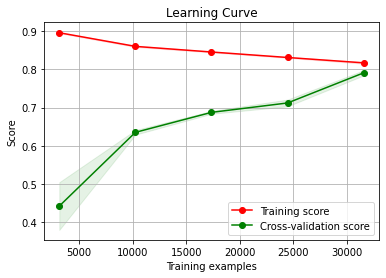

In [73]:
# check the r2 learning curve a specific model and set of features
skplt.estimators.plot_learning_curve(XGB_depth_rfe, X_train_reduced_XGB_depth, y_train, cv=kf, scoring='r2');

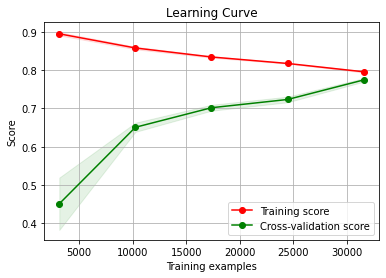

In [74]:
# check the r2 learning curve a specific model and set of features
skplt.estimators.plot_learning_curve(XGB_leaf_rfe, X_train_reduced_XGB_leaf, y_train, cv=kf, scoring='r2');

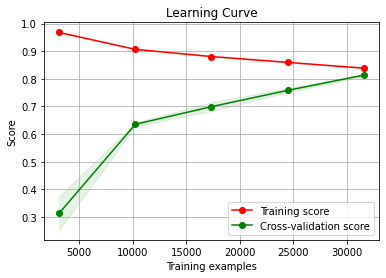

In [75]:
# check the r2 learning curve a specific model and set of features
skplt.estimators.plot_learning_curve(LGBM_rfe, X_train_reduced_LGBM, y_train, cv=kf, scoring='r2');

####Fit models

In [76]:
# fit models
XGB_depth_rfe.fit(X_train_reduced_XGB_depth, y_train)
XGB_leaf_rfe.fit(X_train_reduced_XGB_leaf, y_train)
LGBM_rfe.fit(X_train_reduced_LGBM, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              gamma=0.8, importance_type='split',
              learning_rate=0.42500000000000004, max_depth=3,
              min_child_samples=20, min_child_weight=10.0, min_split_gain=0.0,
              n_estimators=162, n_jobs=-1, num_leaves=29,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.7926214485202859,
              subsample_for_bin=200000, subsample_freq=0)

####Predict on test data

In [77]:
# predict y
y_test_XGB_depth_rfe = XGB_depth_rfe.predict(X_test_reduced_XGB_depth)
y_test_XGB_leaf_rfe = XGB_leaf_rfe.predict(X_test_reduced_XGB_leaf)
y_test_XGB_rfe = LGBM_rfe.predict(X_test_reduced_LGBM)

In [78]:
# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth_rfe'] = np.expm1(y_test_XGB_depth_rfe)
df_test['PM25_nie_pred_xgb_leaf_rfe'] = np.expm1(y_test_XGB_leaf_rfe)
df_test['PM25_nie_pred_lgbm_rfe'] = np.expm1(y_test_XGB_rfe)

In [79]:
# check RMSE for features selected by RFE
xgb_rmse_depth_rfe = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_rfe']))
xgb_rmse_leaf_rfe = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_rfe']))
lgbm_rmse_rfe = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_rfe']))

# check r2 for features selected by RFE
xgb_r2_depth_rfe = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_rfe'])
xgb_r2_leaf_rfe = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_rfe'])
lgbm_r2_rfe = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_rfe'])

In [80]:
print("-----RMSE and r2 results on the test data using features selected by RFE-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_rfe, 100*np.mean(xgb_r2_depth_rfe)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_rfe, 100*np.mean(xgb_r2_leaf_rfe)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_rfe, 100*np.mean(lgbm_r2_rfe)))

-----RMSE and r2 results on the test data using features selected by RFE-----
XGBoost_Depth: RMSE: 7.8459, r2: 43.8%
XGBoost_Leaf: RMSE: 7.9570, r2: 42.2%
LightGBM: RMSE: 8.8968, r2: 27.7%


###Feature Selection: Manual selection

In [81]:
# list of manually selected features ### best performing so far ###
selected_feats = ['year',
                  'dayofyear',
                  'weekday',
                  'hour',
                  'visibility',
                  'humidity',
                  'apparentTemperature',
                  'mean_apparentTemperature_per_month',
                  'temperature',
                  'mean_temperature_per_month',
                  'dewPoint',
                  'dewPoint_rolling168h',
                  'windSpeed_lag1h',
                  'windSpeed_rolling12h',
                  'windSpeed_rolling24h',
                  'windBearing_lag1h',
                  'windBearing_rolling72h',
                  'uvIndex_rolling168h',
                  'temperature_24-72h_ma_diff',
                  'windSpeed_24-72h_ma_diff',
                  'windBearing_24-72h_ma_diff',
                  'humidity_24-72h_ma_diff'
                  ]

In [82]:
# define X_train, y_train
X_train = df_train[selected_feats].values
y_train = df_train['PM25_nie_log'].values

# define X_test, y_test
X_test = df_test[selected_feats].values
y_test = df_test['PM25_nie_log'].values

####Run models

In [83]:
# run hyperopt for XGBoost model with grow_policy='depthwise' and return best results
best_XGB_depth = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='depthwise', cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.3360, r2: 69.9%
RMSE: 0.5623, r2: 15.6%
RMSE: 0.3279, r2: 71.3%
RMSE: 0.3271, r2: 71.4%
RMSE: 0.3151, r2: 73.5%
RMSE: 0.3163, r2: 73.3%
RMSE: 0.3152, r2: 73.5%
RMSE: 0.3350, r2: 70.1%
RMSE: 0.2969, r2: 76.5%
RMSE: 0.3191, r2: 72.8%
100%|██████████| 10/10 [00:17<00:00,  1.74s/it, best loss: 0.2969303656895769]
The best params:  {'colsample_bytree': 0.8500000000000001, 'gamma': 0.9500000000000001, 'learning_rate': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 144, 'subsample': 0.8142399299140823}


In [84]:
# run hyperopt for XGBoost model with grow_policy='lossguide' and return best results
best_XGB_leaf = run_xgb_hyperopt(X_train, y_train, tree_method='hist', grow_policy='lossguide', cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.2797, r2: 79.1%
RMSE: 0.2741, r2: 79.9%
RMSE: 0.3212, r2: 72.5%
RMSE: 0.3695, r2: 63.6%
RMSE: 0.3469, r2: 67.9%
RMSE: 0.3471, r2: 67.8%
RMSE: 0.3294, r2: 71.0%
RMSE: 0.3123, r2: 74.0%
RMSE: 0.3057, r2: 75.1%
RMSE: 0.3318, r2: 70.6%
100%|██████████| 10/10 [00:14<00:00,  1.45s/it, best loss: 0.274149219123441]
The best params:  {'colsample_bytree': 0.9, 'gamma': 0.7000000000000001, 'learning_rate': 0.45, 'max_depth': 3, 'min_child_weight': 6.0, 'n_estimators': 116, 'subsample': 0.9251309694378279}


In [85]:
# run hyperopt for Light GBM model and return best results
best_LGBM = run_lgbm_hyperopt(X_train, y_train, cv=kf, max_evals=10, random_state=random_state)

RMSE: 0.2588, r2: 82.1%
RMSE: 0.2580, r2: 82.2%
RMSE: 0.2981, r2: 76.3%
RMSE: 0.4569, r2: 44.3%
RMSE: 0.2899, r2: 77.6%
RMSE: 0.2767, r2: 79.6%
RMSE: 0.4477, r2: 46.5%
RMSE: 0.2587, r2: 82.1%
RMSE: 0.3193, r2: 72.8%
RMSE: 0.3311, r2: 70.7%
100%|██████████| 10/10 [00:06<00:00,  1.44it/s, best loss: 0.2580040638535074]
The best params:  {'colsample_bytree': 0.9500000000000001, 'gamma': 1.0, 'learning_rate': 0.5, 'max_depth': 3, 'min_child_weight': 8.0, 'n_estimators': 184, 'num_leaves': 25, 'subsample': 0.8771910232585022}


In [86]:
# initiate models with best params
XGB_depth_manual = xgb.XGBRegressor(**best_XGB_depth, objective='reg:squarederror', tree_method='hist', grow_policy='depthwise', random_state=random_state)
XGB_leaf_manual = xgb.XGBRegressor(**best_XGB_leaf, objective='reg:squarederror', tree_method='hist', grow_policy='lossguide', random_state=random_state)
LGBM_manual = lgb.LGBMRegressor(**best_LGBM, objective='regression', random_state=random_state)

####Evaluate models

In [87]:
# evaluate models on KFold
models = [XGB_depth_manual, XGB_leaf_manual, LGBM_manual]

for model in models:
    run_model(model, X_train, y_train, kf)

XGBRegressor RMSE: 0.3000, r2: 75.8%
XGBRegressor RMSE: 0.2788, r2: 79.1%
LGBMRegressor RMSE: 0.2602, r2: 81.8%


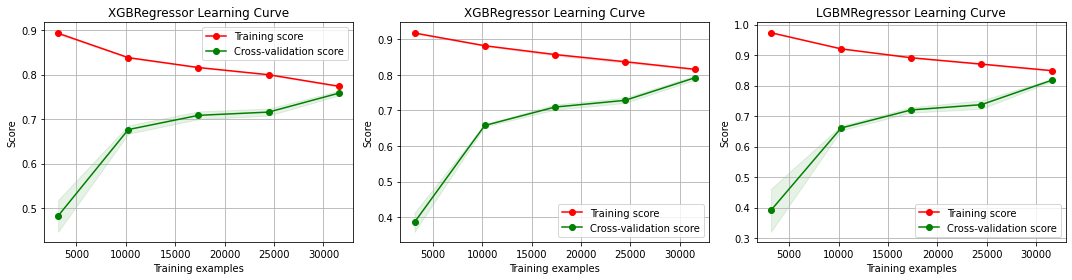

In [88]:
fig=plt.figure(figsize=(15,4))
for i, model in enumerate(models):
    ax=fig.add_subplot(1,3,i+1)
    plot_lear_curve(model, X_train, y_train, kf, 'r2', ax=ax)
fig.tight_layout()
plt.show()

####Fit models

In [89]:
# fit models
XGB_depth_manual.fit(X_train, y_train)
XGB_leaf_manual.fit(X_train, y_train)
LGBM_manual.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.9500000000000001, gamma=1.0,
              importance_type='split', learning_rate=0.5, max_depth=3,
              min_child_samples=20, min_child_weight=8.0, min_split_gain=0.0,
              n_estimators=184, n_jobs=-1, num_leaves=25,
              objective='regression', random_state=2020, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=0.8771910232585022,
              subsample_for_bin=200000, subsample_freq=0)

#### Predict on test data

In [90]:
# predict on all feats 
y_test_XGB_depth_manual = XGB_depth_manual.predict(X_test)
y_test_XGB_leaf_manual = XGB_leaf_manual.predict(X_test)
y_test_LGBM_manual = LGBM_manual.predict(X_test)

# assign predicted results back to the dataframe and redo the log transformation
df_test['PM25_nie_pred_xgb_depth_manual'] = np.expm1(y_test_XGB_depth_manual)
df_test['PM25_nie_pred_xgb_leaf_manual'] = np.expm1(y_test_XGB_leaf_manual)
df_test['PM25_nie_pred_lgbm_manual'] = np.expm1(y_test_LGBM_manual)

In [91]:
# check RMSE for manually selected features
xgb_rmse_depth_manual = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_manual']))
xgb_rmse_leaf_manual = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_manual']))
lgbm_rmse_manual = np.sqrt(mean_squared_error(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_manual']))

# check r2 for manually selected features
xgb_r2_depth_manual = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_depth_manual'])
xgb_r2_leaf_manual = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_xgb_leaf_manual'])
lgbm_r2_manual = r2_score(df_test['PM25_nie'], df_test['PM25_nie_pred_lgbm_manual'])

In [92]:
print("-----RMSE and r2 results on the test data using manually selected features-----")
print("XGBoost_Depth_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_manual, 100*np.mean(xgb_r2_depth_manual)))
print("XGBoost_Leaf_v2: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_manual, 100*np.mean(xgb_r2_leaf_manual)))
print("LightGBM_v2: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_manual, 100*np.mean(lgbm_r2_manual)))

-----RMSE and r2 results on the test data using manually selected features-----
XGBoost_Depth_v2: RMSE: 6.6978, r2: 59.0%
XGBoost_Leaf_v2: RMSE: 7.3216, r2: 51.0%
LightGBM_v2: RMSE: 7.5482, r2: 48.0%


##Compare results

In [93]:
print("-----RMSE and r2 benchmark on the test data using original features-----")
print("Dummy Regressor: RMSE: {:.4f}, r2: {:.1f}%".format(dummy_rmse_orig, 100*np.mean(dummy_r2_orig)))
print("Decision Tree: RMSE: {:.4f}, r2: {:.1f}%".format(dt_rmse_orig, 100*np.mean(dt_r2_orig)))
print("Random Forest: RMSE: {:.4f}, r2: {:.1f}%".format(rf_rmse_orig, 100*np.mean(rf_r2_orig)))
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_orig, 100*np.mean(xgb_r2_orig)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_orig, 100*np.mean(lgbm_r2_orig)))
print(" ")
print("-----RMSE and r2 results on the test data using all features and simple models-----")
print("Decision Tree: RMSE: {:.4f}, r2: {:.1f}%".format(dt_rmse_all, 100*np.mean(dt_r2_all)))
print("Random Forest: RMSE: {:.4f}, r2: {:.1f}%".format(rf_rmse_all, 100*np.mean(rf_r2_all)))
print("XGBoost: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_all, 100*np.mean(xgb_r2_all)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_all, 100*np.mean(lgbm_r2_all)))
print(" ")
print("-----RMSE and r2 results on the test data using all features and optimized models-----")
print("XGBoost_Depth: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth, 100*np.mean(xgb_r2_depth)))
print("XGBoost_Leaf: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf, 100*np.mean(xgb_r2_leaf)))
print("LightGBM: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse, 100*np.mean(lgbm_r2)))
print(" ")
print("-----RMSE and r2 results on the test data using features selected by RFE and optimized models-----")
print("XGBoost_Depth_RFE: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_rfe, 100*np.mean(xgb_r2_depth_rfe)))
print("XGBoost_Leaf_RFE: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_rfe, 100*np.mean(xgb_r2_leaf_rfe)))
print("LightGBM_RFE: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_rfe, 100*np.mean(lgbm_r2_rfe)))
print(" ")
print("-----RMSE and r2 results on the test data using manually selected features and optimized models-----")
print("XGBoost_Depth_manual: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_depth_manual, 100*np.mean(xgb_r2_depth_manual)))
print("XGBoost_Leaf_manual: RMSE: {:.4f}, r2: {:.1f}%".format(xgb_rmse_leaf_manual, 100*np.mean(xgb_r2_leaf_manual)))
print("LightGBM_manual: RMSE: {:.4f}, r2: {:.1f}%".format(lgbm_rmse_manual, 100*np.mean(lgbm_r2_manual)))

-----RMSE and r2 benchmark on the test data using original features-----
Dummy Regressor: RMSE: 10.5207, r2: -1.1%
Decision Tree: RMSE: 10.3966, r2: 1.3%
Random Forest: RMSE: 10.3374, r2: 2.4%
XGBoost: RMSE: 8.4701, r2: 34.5%
LightGBM: RMSE: 8.5642, r2: 33.0%
 
-----RMSE and r2 results on the test data using all features and simple models-----
Decision Tree: RMSE: 8.4815, r2: 34.3%
Random Forest: RMSE: 8.3186, r2: 36.8%
XGBoost: RMSE: 6.8606, r2: 57.0%
LightGBM: RMSE: 6.6977, r2: 59.0%
 
-----RMSE and r2 results on the test data using all features and optimized models-----
XGBoost_Depth: RMSE: 7.4543, r2: 49.2%
XGBoost_Leaf: RMSE: 8.2762, r2: 37.4%
LightGBM: RMSE: 8.4945, r2: 34.1%
 
-----RMSE and r2 results on the test data using features selected by RFE and optimized models-----
XGBoost_Depth_RFE: RMSE: 7.8459, r2: 43.8%
XGBoost_Leaf_RFE: RMSE: 7.9570, r2: 42.2%
LightGBM_RFE: RMSE: 8.8968, r2: 27.7%
 
-----RMSE and r2 results on the test data using manually selected features and opti

In [94]:
# create a list of months in the test dataset
months = df_test.month.unique().tolist()
months

[7, 8, 9, 10, 11, 12]

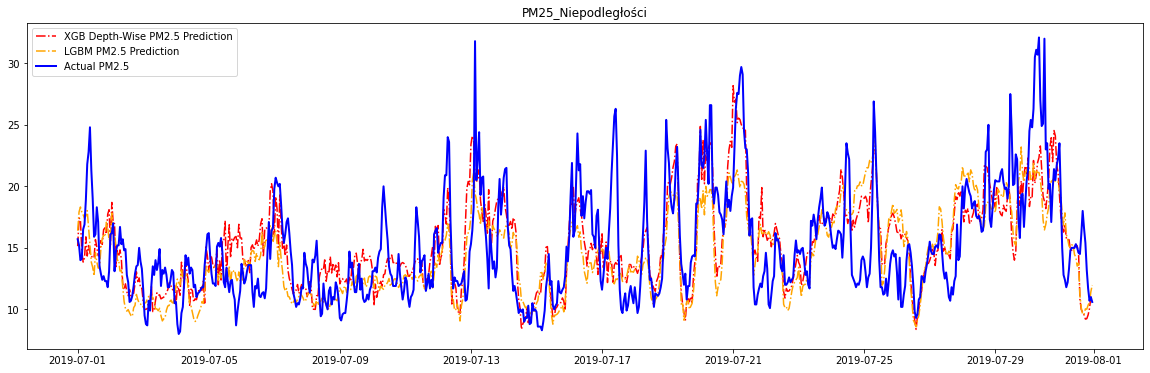

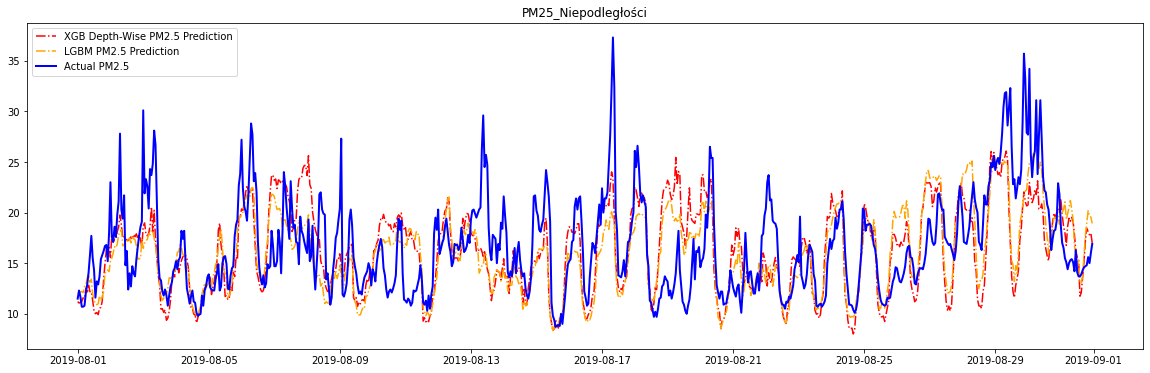

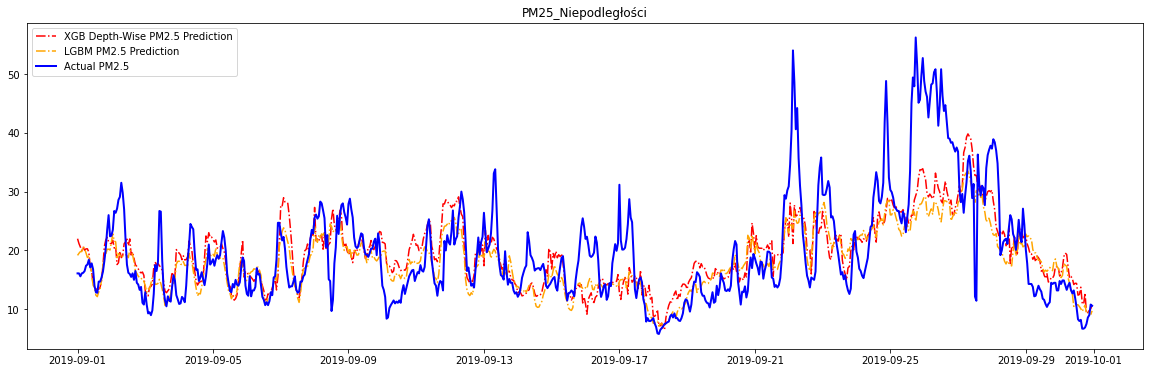

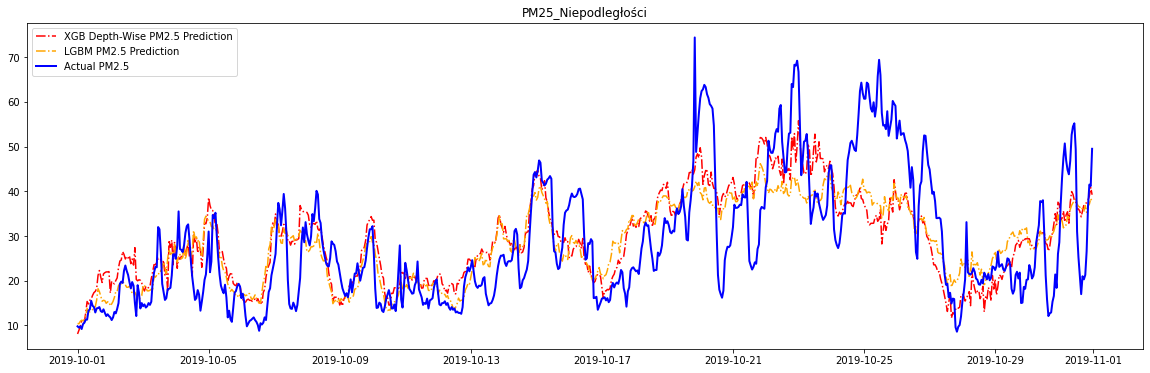

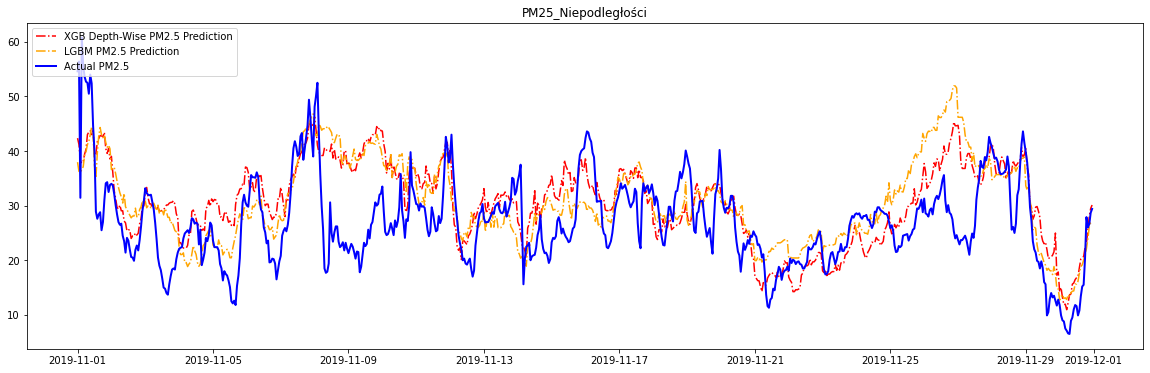

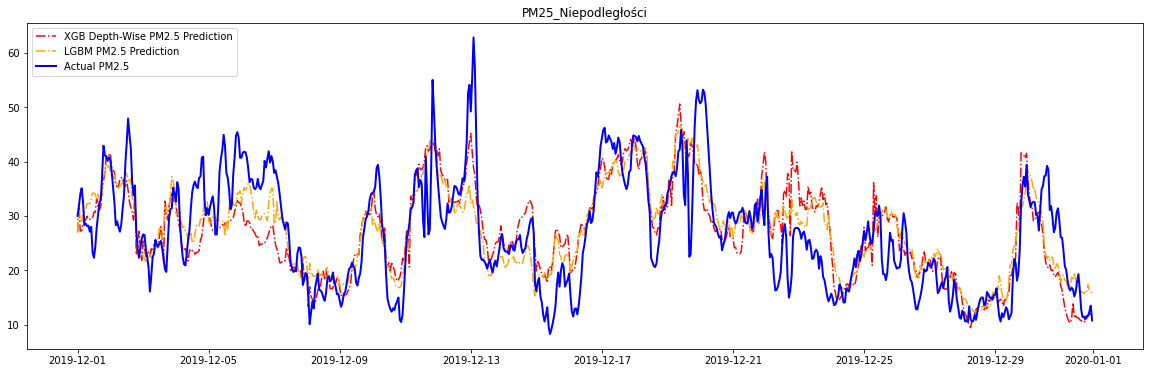

In [95]:
# compare results for each month in the test dataset
for mth in months:
    test_mask = df_test['month'] == mth
    fig, ax = plt.subplots(figsize=(20,6))
    
    #forecast
    ax.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_xgb_depth_manual'],
            color='red', linestyle='dashdot', label='XGB Depth-Wise PM2.5 Prediction')
    #forecast
    ax.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie_pred_LGBM_all'],
            color='orange', linestyle='dashdot', label='LGBM PM2.5 Prediction') 
    #actual
    ax.plot(df_test.loc[test_mask]['datetime'], df_test.loc[test_mask]['PM25_nie'],
            color='blue', linewidth=2, label='Actual PM2.5') 
    
    legend = ax.legend(loc='upper left', fontsize='medium')
    plt.title('PM25_Niepodległości')
    plt.show()